#### Imports and settings

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from random import randint
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
import tensorflow as tf

from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Embedding, GlobalMaxPool1D, LSTM, Dropout, Dense
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import model_from_json
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.initializers import Constant

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=FutureWarning)
    import h5py
tf.logging.set_verbosity(tf.logging.ERROR)

%matplotlib inline
%reload_ext jupyternotify

print('Intel-optimized TensorFlow is enabled:', tf.pywrap_tensorflow.IsMklEnabled())

Using TensorFlow backend.


<IPython.core.display.Javascript object>

Intel-optimized TensorFlow is enabled: True


#### Customize IDE (currently raw)

In [5]:
# Font color on plots 
COLOR = 'A9B0C2'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

plt.rcParams["figure.figsize"] = [10,5]

#### Load datasets and pretrained models

In [6]:
INPUT_PATH = '../input/'
SUBMISSION_PATH = '../submission/'
MODEL_PATH = '../model/'
PRETRAINED_PATH = '../pretrained-models/'

train = pd.read_csv(f'{INPUT_PATH}train.csv')
test = pd.read_csv(f'{INPUT_PATH}test.csv')
test_labels = pd.read_csv(f'{INPUT_PATH}test_labels.csv')

### EDA (Exploratory data analysis)

In [7]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [8]:
test.isnull().any()

id              False
comment_text    False
dtype: bool

In [9]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [10]:
n_train = train.shape[0]
n_test = test.shape[0]
print("Samples in train dataset: ", n_train, "(", round(n_train * 100 / (n_train + n_test)), "% )")
print("Samples in test dataset: ", n_test, "(", round(n_test  *100 / (n_train + n_test)), "% )")

Samples in train dataset:  159571 ( 51 % )
Samples in test dataset:  153164 ( 49 % )


In [11]:
# Do not operate on original test dataset during EDA
train_extended = train.reset_index(drop=True)

In [12]:
comments_labels_train = train_extended.iloc[:,2:]
comments_labels_sums = comments_labels_train.sum(axis=1)
train_extended["clean"] = (comments_labels_sums == 0)
n_clean_samples = train_extended["clean"].sum()
n_toxic_samples = len(train_extended) - n_clean_samples
print("Clean: ", n_clean_samples, "(", round(n_clean_samples * 100 / len(train_extended)), "% )")
print("Toxic: ", n_toxic_samples, "(", round(n_toxic_samples * 100 / len(train_extended)), "% )")

Clean:  143346 ( 90.0 % )
Toxic:  16225 ( 10.0 % )


###### <font color="LIGHTSALMON">The large majority of train dataset are comments labelled as clean</font>

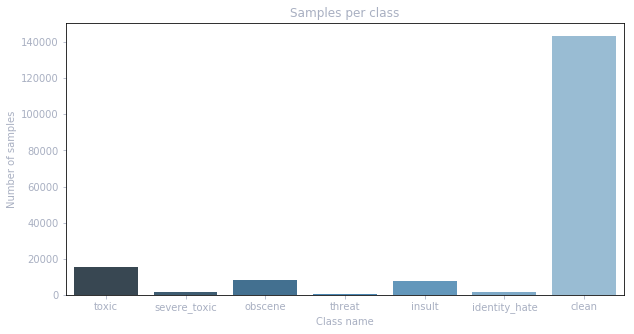

In [13]:
# extended by 'clean' column
summed_labels_extended_train = train_extended.iloc[:,2:].sum()

plt.figure(figsize=(10,5))
plt.title("Samples per class")
plt.ylabel("Number of samples")
plt.xlabel("Class name")
ax = sns.barplot(summed_labels_extended_train.index, summed_labels_extended_train.values, palette="Blues_d")
plt.show()

In [14]:
imbalance_ratios_class_names = {}
imbalance_ratios_class_nums = {}
for label in range(len(summed_labels_extended_train) - 1):
    ratio_label = n_clean_samples / summed_labels_extended_train.get(label)
    imbalance_ratios_class_nums[label] = round(ratio_label, 2)
    imbalance_ratios_class_names[summed_labels_extended_train.index[label]] = round(ratio_label, 2)

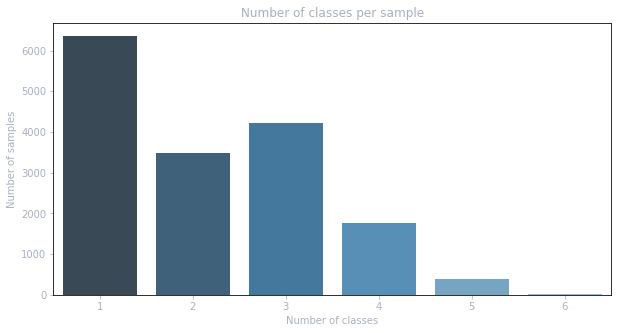

1    6360
3    4209
2    3480
4    1760
5     385
6      31
dtype: int64


In [15]:
# without '0 classes' (clean comments)
multiple_classes_occurance = comments_labels_sums.value_counts().iloc[1:]

plt.figure(figsize=(10,5))
plt.title("Number of classes per sample")
plt.ylabel("Number of samples")
plt.xlabel("Number of classes")
ax = sns.barplot(multiple_classes_occurance.index, multiple_classes_occurance.values, palette="Blues_d")
plt.show()
print(multiple_classes_occurance)

In [16]:
print("Single-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance.get(1) / n_toxic_samples * 100), '%')
print("Multiple-classed toxic comments:", '{0:.2f}'.format(multiple_classes_occurance[1:].sum() / n_toxic_samples * 100), '%')

Single-classed toxic comments: 39.20 %
Multiple-classed toxic comments: 60.80 %


###### <font color="LIGHTSALMON">Most of toxic comments has more than one toxic class</font>

#### Example samples

In [17]:
def get_random_sample(comments_group):
    min_samples_in_class = comments_labels_train.sum().min() - 1
    return comments_group.iloc[randint(0, min_samples_in_class), 1]

In [18]:
toxic_samples = train_extended[train_extended.toxic == 1]
severe_toxic_samples = train_extended[train_extended.severe_toxic == 1]
obscene_samples = train_extended[train_extended.obscene == 1]
threat_samples = train_extended[train_extended.threat == 1]
insult_samples = train_extended[train_extended.insult == 1]
identity_hate_samples = train_extended[train_extended.identity_hate == 1]
clean_samples = train_extended[train_extended.clean == 1]

print("Toxic:\n\n>", get_random_sample(toxic_samples))
print("\n --- \n\nSevere toxic:\n\n>", get_random_sample(severe_toxic_samples))
print("\n --- \n\nObscene:\n\n>", get_random_sample(obscene_samples))
print("\n --- \n\nThreat:\n\n>", get_random_sample(threat_samples))
print("\n --- \n\nInsult:\n\n>", get_random_sample(insult_samples))
print("\n --- \n\nIdentity hate:\n\n>", get_random_sample(identity_hate_samples))
print("\n --- \n\nClean:\n\n>", get_random_sample(clean_samples))

Toxic:

> Yeah, he said he'd never heard of Ferrara, what a crook, the name bad lieutenant just appeared to him in a german sausage.

 --- 

Severe toxic:

> FUCK YOU 

70.17.2.2 Forever

 --- 

Obscene:

> ur so immature fr3nzi3,im 17 and ur not evn debating.ur a 6 year old baby and im like an adult,nobody likes you.anyway,everybody doesn't like any fat assholes like u.grown-ups fight like a man,i fight using words like swearin' like eminem dos in is songs.u don't evn have a brain,shit wat a crazy guy.
user:dark-hooded smoker

 --- 

Threat:

> "

 A knife for you! 

  A knife for you! One of this days, I am going to cut you into little pieces…   "

 --- 

Insult:

> YEAH

looking thorough history and stuff, get a life, you sad little man, get off your arse a get a life, find better things to do than governing things on Wikipedia, I BET UOU LIKE THE SMELL OF YOUR OWN SHIT, I BET YOU GARGLE YOUR OWN PISS, I BET YOU LIKE TO WANK OFF TO KIDDY PORN, YOU SADDO, YOU FUCKING SADDO, FUCK OFF 

#### Wordclouds

#### Spam significance 

In [19]:
train_extended['n_unique_words'] = train_extended["comment_text"].apply(lambda x: len(set(str(x).split())))
train_extended['n_words'] = train_extended["comment_text"].apply(lambda x: len(str(x).split()))
train_extended['unique_words_per'] = train_extended['n_unique_words'] * 100 / train_extended['n_words']

###### <font color="LIGHTSALMON">Spam ratio (coefficient) =  unique words in comment / number of words in comment</font>

In [20]:
spam_ratio = 10
spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
clean_spammers = spammers[spammers['clean'] == True]
toxic_spammers = spammers[spammers['clean'] == False]
n_clean_spammers = clean_spammers.shape[0]
n_toxic_spammers = toxic_spammers.shape[0]
n_spammers = spammers.shape[0]
print('For spam coefficient equal 10%:\n')
print('Clean spammers: ', n_clean_spammers, "(", round(n_clean_spammers * 100 / n_spammers), "% )")
print('Toxic spammers: ', n_toxic_spammers, "(", round(n_toxic_spammers * 100 / n_spammers), "% )")
print('\nThere are', '{0:.2f}'.format(n_toxic_spammers / n_clean_spammers), 
      'times more toxic spammers than clean ones!')

For spam coefficient equal 10%:

Clean spammers:  67 ( 19 % )
Toxic spammers:  292 ( 81 % )

There are 4.36 times more toxic spammers than clean ones!


In [21]:
spam_ratio_values = np.arange(0, 41, 1)
n_clean_spammers_values = []
n_toxic_spammers_values = []
for spam_ratio in spam_ratio_values:
    curr_spammers = train_extended[train_extended['unique_words_per'] < spam_ratio]
    curr_clean_spammers = curr_spammers[curr_spammers['clean'] == True]
    curr_toxic_spammers = curr_spammers[curr_spammers['clean'] == False]
    n_clean_spammers_values.append(curr_clean_spammers.shape[0])
    n_toxic_spammers_values.append(curr_toxic_spammers.shape[0])

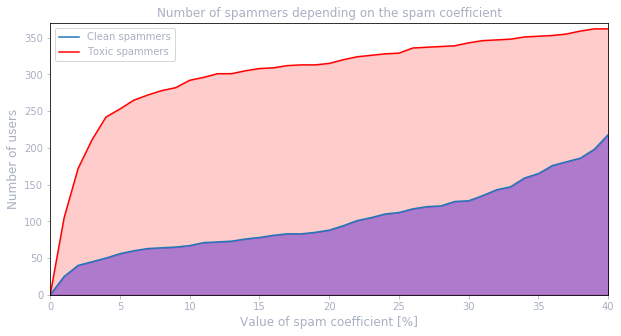

In [22]:
plt.title("Number of spammers depending on the spam coefficient", fontsize=12)

plt.plot(spam_ratio_values, n_clean_spammers_values)
plt.fill_between(spam_ratio_values, n_clean_spammers_values, 0, color='blue', alpha=0.4)  
plt.plot(spam_ratio_values, n_toxic_spammers_values, 'r')
plt.fill_between(spam_ratio_values, n_toxic_spammers_values, 0, color='red', alpha=0.2) 

plt.legend(['Clean spammers', 'Toxic spammers'])
plt.ylabel('Number of users', fontsize=12)
plt.xlabel('Value of spam coefficient [%]', fontsize=12)
plt.xlim(0, 40)
plt.ylim(0, 370)
plt.show()

In [23]:
spam_min_index = min(n_clean_spammers, n_toxic_spammers) - 1
print("Sample clean spam:\n\n>", clean_spammers.iloc[randint(0, spam_min_index)].comment_text)
print("\n --- \n\nSample toxic spam:\n\n>", toxic_spammers.iloc[randint(0, spam_min_index)].comment_text)

Sample clean spam:

> OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY.
OH LAWDY

### Prepare data for model training

#####  Custom Tokenizer

In [24]:
classes_names = train.columns.values[2:]
labels_train = train[classes_names].values
comments_train = train["comment_text"]
comments_test = test["comment_text"]

In [25]:
num_words = 25000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(list(comments_train))
print('Found %d unique words.' % len(tokenizer.word_index))

Found 210337 unique words.


In [26]:
# Check first 20 unique words with the highest occurance from our dictonary
dict(list(tokenizer.word_index.items())[0:20])

{'the': 1,
 'to': 2,
 'of': 3,
 'and': 4,
 'a': 5,
 'you': 6,
 'i': 7,
 'is': 8,
 'that': 9,
 'in': 10,
 'it': 11,
 'for': 12,
 'this': 13,
 'not': 14,
 'on': 15,
 'be': 16,
 'as': 17,
 'have': 18,
 'are': 19,
 'your': 20}

##### Pre-trained GloVe model

In [27]:
glove_model = f'{PRETRAINED_PATH}glove.6B.100d.txt'

embeddings_index = {}
f = open(glove_model, encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [28]:
# Prepare embedding matrix
custom_word_index = tokenizer.word_index
embedding_output_dim = 100

resultant_num_words = min(num_words, len(custom_word_index)) + 1
embedding_matrix = np.zeros((resultant_num_words, embedding_output_dim))

for word, i in custom_word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

#####  Comments tokenizing

In [29]:
tokenized_sequences_train = tokenizer.texts_to_sequences(comments_train)
tokenized_sequences_test = tokenizer.texts_to_sequences(comments_test)

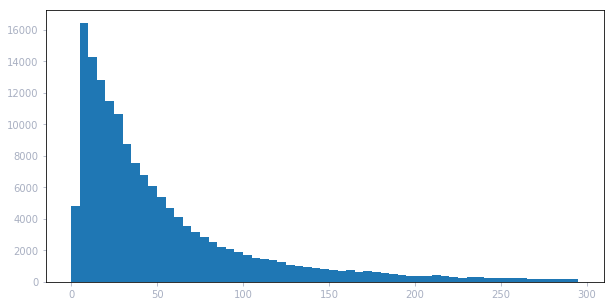

In [30]:
# Analysis of lengths of comments (maxlen param)
n_words_comments = [len(comment) for comment in tokenized_sequences_train]
plt.hist(n_words_comments, bins=np.arange(0,300,5))
plt.show()

##### Vector padding

In [31]:
maxlen = 180
fixed_sequences_train = pad_sequences(tokenized_sequences_train, maxlen=maxlen)
fixed_sequences_test = pad_sequences(tokenized_sequences_test, maxlen=maxlen)

print('Before padding: (', len(tokenized_sequences_train[6]) ,'elements )\n', tokenized_sequences_train[6])
print('\nAfter padding: (', len(fixed_sequences_train[6]) ,'elements )\n', fixed_sequences_train[6])

Before padding: ( 8 elements )
 [1873, 147, 6, 3476, 324, 15, 29, 141]

After padding: ( 180 elements )
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0 1873  147    6 3476  3

##### <font color="red">!</font> Oversampling

In [32]:
# One column in y_train is cut

from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN

X_train = fixed_sequences_train
y_train = labels_train

adasyn = ADASYN(random_state=42)
smote = SMOTE(random_state=42)
ros = RandomOverSampler(random_state=0)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
print(X_train.shape, y_train.shape)
print(X_resampled.shape, y_resampled.shape)

(159571, 180) (159571, 6)
(793200, 180) (793200, 5)


### Building the model

In [33]:
# Params for model training
batch_size = 64
epochs = 2
n_classes = len(classes_names)

##### Tuning params with Grid Search

In [34]:
def create_model(lstm_units = 100, 
                 lstm_recurrent_dropout = 0.2, 
                 lstm_return_sequences = True, 
                 dropout_rate = 0.2, 
                 relu_dense_units = 50, 
                 optimizer = 'adam'):
    model = Sequential()
    model.add(Embedding(input_dim=resultant_num_words,
                        output_dim=embedding_output_dim,
                        embeddings_initializer=Constant(embedding_matrix),
                        input_length=maxlen,
                        trainable=False))
    model.add(LSTM(units=lstm_units, 
                   return_sequences=lstm_return_sequences, 
                   recurrent_dropout=lstm_recurrent_dropout))
    model.add(GlobalMaxPool1D())
    model.add(Dropout(rate=dropout_rate))
    model.add(Dense(units=relu_dense_units, activation='relu'))
    model.add(Dense(n_classes, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
    return model

In [35]:
param_grid = {
    'lstm_units': [100],
    'dropout_rate': [0.2],
    'optimizer': ['adam'],
    'relu_dense_units': [50],
    'lstm_recurrent_dropout': [0.2],
    'lstm_return_sequences': [True]
}

In [36]:
# Define callbacks
name_checkpoint_file = 'checkpoint.weights.hdf5'
checkpoint = ModelCheckpoint(filepath=f'{MODEL_PATH}{name_checkpoint_file}',
                             monitor='val_loss',
                             mode='min',
                             verbose=2,
                             save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', mode="min", patience=20)

callbacks_list = [checkpoint, early_stopping]

In [74]:
model = KerasClassifier(build_fn=create_model, 
                        epochs=epochs, 
                        batch_size=batch_size, 
                        validation_split=0.1,
                        verbose=2)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)

### Model training

In [75]:
X_train = fixed_sequences_train
y_train = labels_train

grid_result = grid.fit(X_train, y_train, class_weight=imbalance_ratios_class_nums, callbacks=callbacks_list)

Train on 95742 samples, validate on 10638 samples
Epoch 1/2
 - 314s - loss: 0.9294 - acc: 0.9733 - val_loss: 0.6536 - val_acc: 0.9789

Epoch 00001: val_loss improved from inf to 0.65362, saving model to ../model/checkpoint.weights.hdf5
Epoch 2/2
 - 310s - loss: 0.6420 - acc: 0.9798 - val_loss: 0.5620 - val_acc: 0.9800

Epoch 00002: val_loss improved from 0.65362 to 0.56199, saving model to ../model/checkpoint.weights.hdf5
Train on 95742 samples, validate on 10639 samples
Epoch 1/2
 - 304s - loss: 0.8694 - acc: 0.9740 - val_loss: 0.5984 - val_acc: 0.9792

Epoch 00001: val_loss did not improve from 0.56199
Epoch 2/2
 - 302s - loss: 0.6215 - acc: 0.9798 - val_loss: 0.5470 - val_acc: 0.9801

Epoch 00002: val_loss improved from 0.56199 to 0.54696, saving model to ../model/checkpoint.weights.hdf5
Train on 95742 samples, validate on 10639 samples
Epoch 1/2
 - 307s - loss: 0.9256 - acc: 0.9722 - val_loss: 0.6044 - val_acc: 0.9807

Epoch 00001: val_loss did not improve from 0.54696
Epoch 2/2
 -

In [76]:
print("Best params:\n %s (score: %f)" % (grid_result.best_params_, grid_result.best_score_))

Best params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50} (score: 0.980902)


In [77]:
params = grid_result.cv_results_['params']
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
print('All results:')
for param, mean, std in zip(params, means, stds):
    print('\nSet of params:\n %r\n Mean: (%f); Standard deviation: %f' % (param, mean, std))

All results:

Set of params:
 {'dropout_rate': 0.2, 'lstm_recurrent_dropout': 0.2, 'lstm_return_sequences': True, 'lstm_units': 100, 'optimizer': 'adam', 'relu_dense_units': 50}
 Mean: (0.980902); Standard deviation: 0.000364


##### Save and load model

In [78]:
name_model_file = 'glove-embeddings.model.json'
name_weights_file = 'glove-embeddings.weights.h5'

def save_model_to_JSON(model):
    model_json = model.to_json()
    with open(f'{MODEL_PATH}{name_model_file}', 'w') as json_file:
        json_file.write(model_json)
    print('Saved model to disk')
        
def save_weights_to_HDF5(model):
    model.save_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Saved weights to disk')

def load_json_wih_weights_to_model(name_model_file, name_weights_file):
    json_file = open(f'{MODEL_PATH}{name_model_file}', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(f'{MODEL_PATH}{name_weights_file}')
    print('Loaded model with weights from disk')
    return loaded_model

In [79]:
# Save model
best_model = grid_result.best_estimator_.model
save_model_to_JSON(best_model)
save_weights_to_HDF5(best_model)

Saved model to disk
Saved weights to disk


In [80]:
# Load model
loaded_model = load_json_wih_weights_to_model(name_model_file, name_weights_file)
loaded_model.summary()

Loaded model with weights from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 180, 100)          2500100   
_________________________________________________________________
lstm_4 (LSTM)                (None, 180, 100)          80400     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 306       
Total params: 2,585,856
Trainable params: 85,756
Non-trainable params: 2,500,100
_________________________

##### Predicting on test dataset

In [41]:
def drop_entries_with_invalid_labels(test, test_labels):
    indexes_invalid_labels = test_labels.index[test_labels['toxic'] == -1].tolist()
    valid_test_labels = test_labels.drop(test_labels.index[indexes_invalid_labels])
    valid_test = np.delete(test, indexes_invalid_labels, axis=0)
    assert (valid_test_labels.shape[0] == len(valid_test))
    return valid_test, valid_test_labels

In [42]:
test_labels_without_ids = test_labels.iloc[:,1:]
X_test, y_test_df = drop_entries_with_invalid_labels(fixed_sequences_test, test_labels_without_ids)

y_pred_float = loaded_model.predict([X_test], batch_size=1024)
y_pred = (y_pred_float > .5)
y_test = y_test_df.values

##### <font color="red">!</font> Use metrics for imbalanced learning

In [52]:
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import precision_recall_fscore_support as score
from imblearn.metrics import specificity_score, sensitivity_score

precision, recall, fscore, support = score(y_test, y_pred)
kappa = cohen_kappa_score(y_test.ravel(), y_pred.ravel())
specificity = specificity_score(y_test.ravel(), y_pred.ravel())
sensitivity = sensitivity_score(y_test.ravel(), y_pred.ravel())

c:\users\andrz\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [53]:
print('Precision: \t', list(map('{:.3f}'.format, precision)))
print('Recall: \t', list(map('{:.3f}'.format, recall)))
print('F1 score: \t', list(map('{:.3f}'.format, fscore)))
print('Support: \t', support)
print('\n --- \n')
print('Kappa score: \t{:.3f}'.format(kappa))
print('Specificity: \t{:.3f}'.format(specificity))
print('Sensitivity: \t{:.3f}'.format(sensitivity))

Precision: 	 ['0.586', '0.448', '0.640', '0.000', '0.617', '0.000']
Recall: 	 ['0.806', '0.117', '0.764', '0.000', '0.635', '0.000']
F1 score: 	 ['0.678', '0.186', '0.696', '0.000', '0.626', '0.000']
Support: 	 [6090  367 3691  211 3427  712]

 --- 

Kappa score: 	0.629
Specificity: 	0.982
Sensitivity: 	0.686


Confusion matrices:


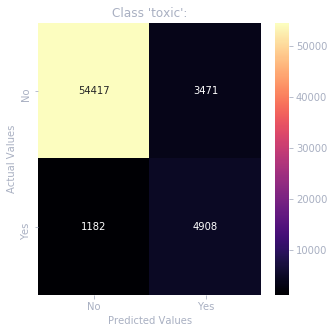

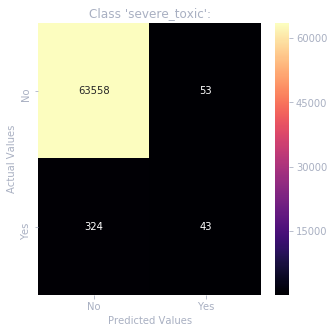

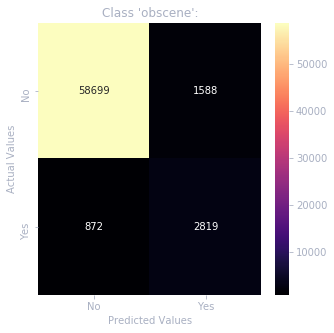

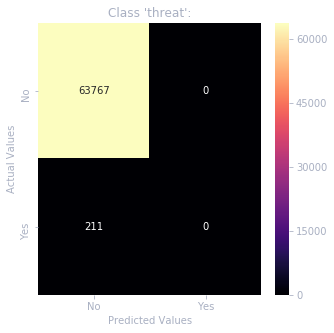

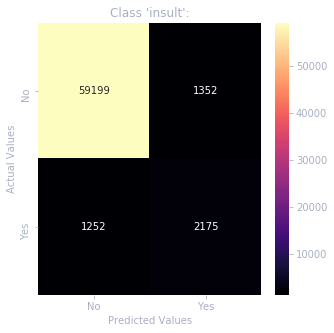

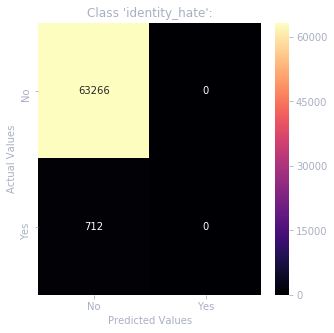

In [54]:
conf_matrices = {}
for label in range(len(classes_names)):
    y_test_label = y_test[:, label]
    y_pred_label = y_pred[:, label]
    conf_matrices[classes_names[label]] = confusion_matrix(y_pred=y_pred_label, y_true=y_test_label)
    
print("Confusion matrices:")
for label, matrix in conf_matrices.items():
    df_cm = pd.DataFrame(matrix, index = [i for i in ['No', 'Yes']], columns = [i for i in ['No', 'Yes']])
    plt.figure(figsize = (5, 5))
    ax = plt.axes()
    sns.heatmap(df_cm, annot=True, cmap='magma', fmt='g')
    ax.set_title("Class '{}':".format(label))
    ax.set_ylabel('Actual Values')    
    ax.set_xlabel('Predicted Values')
    plt.show()

##### Create submission file

##### Manual model testing

In [55]:
def prepare_comment(comment):
    tokenized_comment = tokenizer.texts_to_sequences(comment)
    return pad_sequences(tokenized_comment, maxlen=maxlen)

In [70]:
single_comment = 'Meh!'
single_prediction = loaded_model.predict([prepare_comment([single_comment])], batch_size=1024)
results = pd.DataFrame(single_prediction, columns=[classes_names])

class_with_highest_prob = results.idxmax(axis=1).get(0)[0]
highest_prob = results.max(axis=1).get(0)

happy_face = '\ (•◡•) /'
sad_face = '¯\_(ツ)_/¯'

if (highest_prob > .5):
    print('\nDeteced class: ', class_with_highest_prob, '\nScore: ', highest_prob * 100, ' %\n\n', sad_face)
else:
    print('\nNo toxicity detected!\n\n', happy_face)
print('\nAll results:\n', results)


No toxicity detected!

 \ (•◡•) /

All results:
       toxic severe_toxic   obscene    threat   insult identity_hate
0  0.011582     0.000065  0.002869  0.001177  0.00186      0.001015


##### <font color="#7affa0">TODO:</font>
- <font color="green">✔</font> add plot of spammers classification based on variable spam_ratio
- try to use new features from EDA during model fitting (e. g. spam)
- ⌛ execute SearchGrid of model's params
    - ⌛ try diffrent values of non-model params num_words (Tokenizer), maxlen (padding)
- <font color="green">✔</font> update Tensorflow to GPU version
- try diffrent architectures:
    - ⌛ Pooling (Max -> Average)
    - <font color="green">✔</font> Early Stopping and Checkpoints (callbacks)
    - <font color="green">✔</font> Pretrained Embedding (Glove)

##### <font color="#a07aff">Konsultacje:</font>
- Klasyfikacja dwupoziomowa: binarna (clean/toxic data) + wieloetykietowa (tylko toxic data); dwa klasyfikatory
- <font color="green">✔</font> Dataset jest niezrównoważony (10/90); klasyfikacja niezrównoważona
- Oversampling
- <font color="green">✔</font> Sprawdzić macierz pomyłek
- <font color="green">✔</font> Klasyfikacja hierarchiczna (np. severe toxic zawsze jest toxic)
- <b>Zrobić przegląd literatury</b>